### Detecting and filtering outliers

A common first step is to investigate the nature of the outlier candidates within the context of our data. We can choose how we handle the samples, whether to remove them from the dataset, flag them within the data, or ignore them. As our decisions may vary depending on the intended use case, domain knowledge, or other analytical results, it is always important to clearly document any observations and the resulting decisions.

#### Outliers v/s errors 
Some abnormal values can be the result of errors in the data and should be addressed in any case. Unlike errors, we consider outliers as legitimate values that are different or rare. When we discuss outliers below and in other units, we will assume that we have already cleared out the errors.

#### Why do we care about outliers or anomalies?
* Outliers can affect certain statistical measures like mean, variance, or correlation coefficients.
* Thus they might require us to exclude them from our analysis or to adjust our analysis.
* Outliers can adversely influence preprocessing techniques for machine learning, e.g. standardization.
* Since models are fitted to data, for some models outliers in the data can affect the model parameters that we try to optimize and thus our ability to make good predictions. For that reason, we may consider removing outliers from the data prior to fitting these models. We will also see models that can handle outliers.

#### Outliers can hold valuable information

Outliers are often seen as abnormal and undesirable. However, in some fields, they can provide sought-after insights.

* Recognizing outliers in user behavior can help credit card firms identify potential fraud and network administrators identify attempted cyber attacks.
* In production cycles, outliers can help identify defective products that should not enter circulation.
* In predictive maintenance, outliers in time-series data for sensors and machines can be signs of imminent problems and a potential breakdown. Recognizing this early allows firms to intervene quickly and save time and money.
* In science, outliers might give rise to unobserved phenomena (novelties) that advance our understanding of the field and down the line, the outlier in today’s observational data becomes a standard part of tomorrow’s textbooks.

#### Practical outlier removal
In this unit, we will describe three methods for outlier detection and removal: by inspection, z-scores and boxplots. Here we will focus on outliers within single features.

Let’s start a new notebook by importing the required libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The first 5 features are created with the random.randn() function from NumPy. Concretely, as the documentation of the function states, it will return the array “filled with random floats sampled from a univariate “normal” (Gaussian) distribution of mean 0 and variance 1”. For the 5th feature, we will manually introduce outliers by adding 1000 to the last 100 values (i.e. 0.1% of our samples). Finally, we will add a 6th feature with values sampled from an exponential distribution as an illustrative example that exhibits skewness. A seed will be incorporated for the randomly created distributions.

In [3]:
# Create a random seed to make result reproducible
np.random.seed(0)

# Create 5 features with 100000 samples from Gaussian distribution each
df = pd.DataFrame(np.random.randn(100000, 5))

# Add 1000 to the last 100 values of feature 4
df.iloc[-100:, 4] = df.iloc[-100:, 4] + 1000

# Create 6th feature with 100000 samples from exponential distribution
df[5] = np.random.exponential(1, 100000)

# Change feature names
df = df.add_prefix("X")
df.head()

,X0,X1,X2,X3,X4,X5
0,1.764052,0.400157,0.978738,2.240893,1.867558,0.540426
1,-0.977278,0.950088,-0.151357,-0.103219,0.410599,1.424513
2,0.144044,1.454274,0.761038,0.121675,0.443863,0.282623
3,0.333674,1.494079,-0.205158,0.313068,-0.854096,0.038750
4,-2.552990,0.653619,0.864436,-0.742165,2.269755,0.999036


There does not seem to be much difference between these values. The values of the last feature are all positive, but that could be by chance.

#### Checking descriptive statistics and visualizations
A good first step is to check some common statistics.

In [5]:
df.describe().round(5)

,X0,X1,X2,X3,X4,X5
count,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000
mean,-0.00020,0.00235,0.00161,0.00196,1.00745,1.00622
std,0.99711,0.99915,1.00225,1.00057,31.61742,1.00696
min,-4.69459,-4.85212,-4.24712,-4.44663,-5.00230,0.00000
25%,-0.67891,-0.66917,-0.67574,-0.67561,-0.66450,0.29055
50%,0.00263,0.00315,0.00039,0.00118,0.00851,0.69563
75%,0.67424,0.67192,0.67740,0.67603,0.68245,1.39619
max,4.46661,4.22408,4.28586,4.24177,1002.53804,11.80068


for feature X5, we have a mean and std of 1 and the median is around two thirds between the minimum and the mean. Moreover, the minimum is 1 std away from the mean while the maximum is almost 11 std away from the mean. This suggests the data is right-skewed, i.e a longer tail on the right. We will need to take a closer look.

In the following, we will focus only on the features X0, X4 and X5.

Since individual statistical metrics reduce the data to single numbers, it is better to take a look at distribution plots. The plot might already indicate outlier candidates by visual inspection. Moreover, it might give us some indication of whether any of the distribution resembles a common probability distribution. We could thus use these statistical distributions to define our ‘normal’ for the outliers.
We take a look at histograms and boxplots. There are other options like violin plots, distplots, etc.

In [1]:
fig, axes = plt.subplots(
    2, 3, gridspec_kw={"height_ratios": (0.7, 0.3)}, figsize=(15, 6)
)

for (feat, plot_col) in zip(
    ["X0", "X4", "X5"], [0, 1, 2]  # pairing feature with column in plot
):
    axes[0, plot_col].hist(df[feat], bins=50)
    axes[0, plot_col].set_title("Histogram and boxplot for {}".format(feat))
    sns.despine(ax=axes[0, plot_col])
    sns.boxplot(data=df[feat], orient="h", ax=axes[1, plot_col], fliersize=2)
    axes[1, plot_col].set(yticks=[])
    sns.despine(ax=axes[1, plot_col], left=True)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

NameError: name 'plt' is not defined

Some observations:

* Feature X0: The distribution is symmetric, bell-shaped, and centered around 0.
* Feature X4: The histogram only appears to have a single bar. But the x-axis is drawn up to 1000 indicating that there is some data as far out as 1000. This is in line with the maximum value in df.describe()and the boxplot further confirms this.
* Feature X5: The plot confirms our concern about right-skewness.

#### Manual outlier removal

A simple way to identify outlier candidates is by visual inspection. We can set bounds manually and use them to isolate the outliers. We saw above that the maximum value, the histogram, and the boxplot for X4 indicated that the values can go up to 1000. But the histogram is not detailed enough because the data near 0 dominates the frequency counts, while the boxplot suggests a single outlier point. We can use a log-scale for the y-axis to reveal the small group of  100 values near 1000.

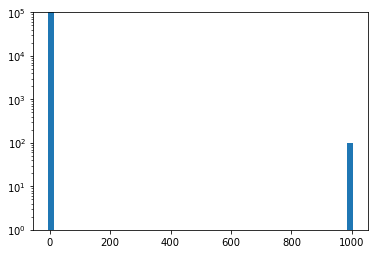

In [7]:
plt.hist(df["X4"], bins=50)
plt.yscale("log")
plt.ylim(1, 100000)
plt.show()

As this group makes up only 0.1% we would likely consider them as outliers and set an upper bound at 200, say, to first identify and then remove these samples.



In [8]:
filter_200 = df["X4"] > 200
outliers_manual = df.loc[filter_200, "X4"]
outliers_manual.head()

99900     999.019554
99901    1000.315769
99902    1000.443100
99903    1001.435870
99904    1000.534458
Name: X4, dtype: float64

Using ~ to invert our filter we can remove all the outliers.

In [9]:
df_keep = df.loc[~filter_200, "X4"]
df_keep.shape

(99900,)

#### Using Z-scores to identify outlier candidates
A common method for deciding what constitutes an outlier for data that is approximately normally distributed is the “3 times the standard deviation from the mean” rule. Suppose we have a value x, and we want to decide if it is an outlier or not. Let μ be the mean value of our dataset. We then look at |x−μ|(recall ||denotes the absolute value), which measures how far away x is from the mean. If this absolute value is more than 3 times the standard deviation σ of the dataset, then x is considered an outlier.

In [10]:
zfilterX0 = np.abs(df["X0"] - df["X0"].mean()) > (3 * df["X0"].std())
zfilterX0.head()

0    False
1    False
2    False
3    False
4    False
Name: X0, dtype: bool

We can see that this returns a Series of booleans so we can now use this to do boolean indexing. For example, this command returns the first 5 outlier entries of df["X0"].



In [11]:
df.loc[zfilterX0, "X0"].head()

1470    3.211847
2763   -3.694285
3178   -3.007413
3809    3.301367
3833   -3.432215
Name: X0, dtype: float64

We can also apply this step to all the five columns at once. If we compute the filter across the entire DataFrame as supposed to the first column we just obtain a DataFrame of boolean values. Let’s try this out

In [14]:
zfilter_df = np.abs(df - df.mean()) > (3 * df.std())
zfilter_df.head(5)

,X0,X1,X2,X3,X4,X5
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False


Thus the “3 times the standard deviation from the mean” rule translates into |z|>3 (z=(x−μ)/σ)

In [15]:
zscores_df = (df - df.mean()) / (df.std())
zfilter_df2 = np.abs(zscores_df) > 3

# Check the two zfilters are identical
print("Both approaches are equivalent:", zfilter_df.equals(zfilter_df2))

Both approaches are equivalent: True


#### Filter outliers of single features

Let’s check how many outliers we have for each feature. We can use the sum() function as False is counted as 0 and True is counted as 1. We can specify the direction of summation:

* axis=0 sums along the columns,
* axis=1 sums along the rows.

In [17]:
print("Number of outliers detected per feature using z-scores:")
print(zfilter_df.sum(axis=0))
print("Total number of outliers detected:", zfilter_df.sum(axis=0).sum())

Number of outliers detected per feature using z-scores:
X0     255
X1     290
X2     272
X3     271
X4     100
X5    1858
dtype: int64
Total number of outliers detected: 3046


You may remember that roughly 99.73% of the values of a normal distribution lie within the  interval, which means that roughly 0.27% lie outside of it. And indeed, for the features X0 to X3, we get around 270 outliers.

Outliers and skewness affect the mean and the standard deviation and in turn, they affect the z-scores calculated from them.

The larger number of outliers candidates for feature X5 is due to the large right-hand tail (right-skewness) of the exponential distribution, which does not follow the behavior of a normal distribution. (In fact, to find an interval around the mean that contains around 99.75% of the exponential distribution we would need use 5 standard deviations

#### Filtering outliers using all features

Now we would like to use our filter to select all rows which have a True value in any of the columns. We can do this using pandas’ any() function, which returns a Series of booleans. We have two ways of applying it:

* axis=0 gives a value to each column: True if there was a True entry anywhere in the column, and False otherwise
* axis=1 gives a value to each row: True if there was a True entry anywhere in the row, and False otherwise.
We are interested in the second option since we want to detect all rows that have an outlier value in any of the five columns. Let’s give it a go:


In [18]:
zfilter_any = zfilter_df.any(axis=1)
zfilter_any.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

Let’s finally select all the rows now using zfilter_any

In [19]:
outliers = df.loc[zfilter_any, :]
outliers.shape

(3018, 6)

Note that we got fewer outliers than the 3046 we calculated earlier. This is due to the fact that some samples were flagged as outliers in more than 1 column.

We can now define a new DataFrame where the rows with outliers are dropped:



In [20]:
df_wo = df.drop(outliers.index, axis=0)

#### Using the interquartile range to identify outlier candidates
Two advantages of boxplots are that they are based on robust statistics (quartiles and the IQR) and that they highlight outlier candidates in the plot. Let’s take a look at the plots again.

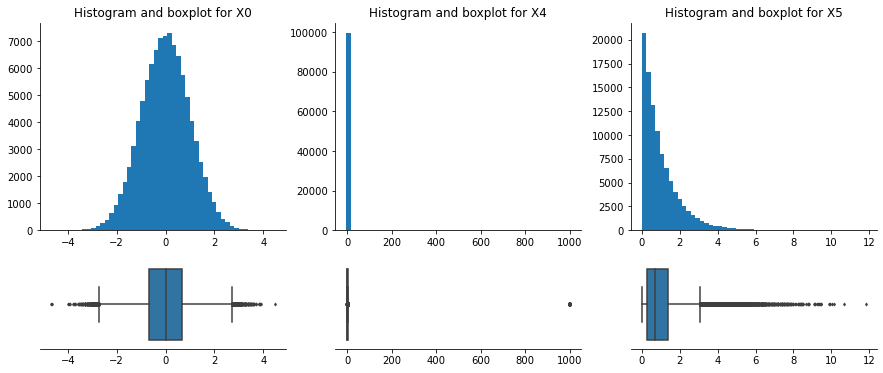

In [21]:
fig, axes = plt.subplots(
    2, 3, gridspec_kw={"height_ratios": (0.7, 0.3)}, figsize=(15, 6)
)

for (feat, plot_col) in zip(
    ["X0", "X4", "X5"], [0, 1, 2]  # pairing feature with column in plot
):
    axes[0, plot_col].hist(df[feat], bins=50)
    axes[0, plot_col].set_title("Histogram and boxplot for {}".format(feat))
    sns.despine(ax=axes[0, plot_col])
    sns.boxplot(data=df[feat], orient="h", ax=axes[1, plot_col], fliersize=2)
    axes[1, plot_col].set(yticks=[])
    sns.despine(ax=axes[1, plot_col], left=True)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

Let’s identify the outliers flagged in the boxplot method by calculating the upper and lower bounds directly from the IQR of each feature.



In [22]:
Q1 = np.percentile(df, 25, axis=0)
Q3 = np.percentile(df, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print lower and upper bound for X0
print("Lower bound: {:.4f}, upper bound: {:.4f}".format(lower_bound[0], upper_bound[0]))

Lower bound: -2.7087, upper bound: 2.7040


Observation: As X0 was drawn from a standard normal distribution these bounds correspond to roughly 2.7 standard deviations either side of the mean. So this is a smaller interval than the one for the 3 standard deviations from the mean rule. However, we could choose a higher multiple of the IQR when calculating the above bounds and thus flag only the most extreme outliers.

We now use boolean indexing to select the entries which lie outside our bounds. Let’s check how many outliers are identified by the boxplot in each feature.

In [23]:
boxplot_filter = (df < lower_bound) | (df > upper_bound)
print("Number of outliers detected per feature using a boxplot:")
print(boxplot_filter.sum(axis=0))
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())

Number of outliers detected per feature using a boxplot:
X0     648
X1     757
X2     679
X3     687
X4     818
X5    4742
dtype: int64
Total number of outliers detected: 8331


Observe that for X4 the boxplot still flags 818 outliers for the data near 0, while the z-score only gave the 100 data values near 1000. This is because the quartiles and the interquartile range are robust statistics that are unaffected by this small set of data points near 1000.

### Problems with outlier detection methods
#### The data contains multiple sub-populations

Consider data about people’s monthly spending. We might identify groups with different behavior, e.g people commuting to work by car, bike, or public transport. It would be unreasonable to consider any group as outliers or exclude them entirely from the analysis.
When we have sub-populations we might wish to identify these individual groups and then analyze them for outliers in isolation, potentially using different techniques for different groups. For example, after some investigations, we might decide that the samples near 1000 in X4 are not outliers but that they form a (very) small subpopulation that should be treated separately.

#### Outliers can affect statistics and thus outlier detection

As we have seen for X4 statistics like the mean and the standard deviation are affected by the presence of a few outliers. As a result, so were the z-scores. This clearly affected the number of outlier candidates. One option is to work with robust statistics, like the median, that are less affected by outliers. For example, robust z-scores mimic the idea of z-scores but the mean is replaced by the median and the standard deviation by the median absolute deviation (MAD).

#### The distribution of feature values is skewed

Both z-scores and boxplots assume the data is roughly symmetrically distributed around the ‘center’ of the data and they measure a distance from this center to identify possible outliers in both directions. As the feature X5 shows, skewness affects the number of identified outliers by both methods. 

Unless the data distribution looks vaguely like a Gaussian distribution, i.e. the distribution is a single population that is approximately symmetric and bell-shaped, then z-scores are not suitable and you should consider other methods like visual inspection, other statistical tests, or even machine learning approaches for outlier detection.
We can sometimes reduce skewness by applying different transformations to the data to make it approximately Gaussian and then apply z-scores or boxplots. We will see more about using transformations later in the program.
Alternatively, one can choose a different multiplier in the definition of the fence and the whiskers of the boxplot; one can use adjusted boxplots, which are based on various measures of skewness to define individual lengths for the two whiskers.

Note that despite some shortcomings, z-scores are commonly used in data science as they are fast and easy to implement on large datasets, for example, we don’t need to sort the data first to identify the median or the quartiles. Thus in later units, we will apply z-scores, potentially having transformed the data first. However, you are welcome to explore alternatives like robust z-scores.

### Outliers for combinations of features

In this scatterplot, we plot the z-scores of features X0 and X1. We have plotted in orange all points that were flagged as outliers in one of the two features. The light blue rectangular region is considered ‘normal’ by both features according to the z-score method. However, it appears that most of the points form a disc, i.e. the boundary of the ‘normal’ region appears to be circular. (The radius of the circle was simply chosen by inspection.) From this perspective, some points in the corners of the rectangle could be considered outliers now, while some of the outlier candidates now fall into the new ‘normal’ region. The choice of which points to consider outliers and how to handle them is ours to make and may depend on the context.


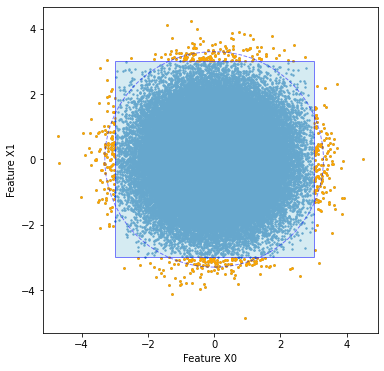

In [24]:
fig = plt.figure(figsize=(6, 6))
# Mark square corresponding to zone 3 std from the means of X0 and X1
rectangle = plt.Rectangle((-3, -3), 6, 6, fc="lightblue", ec="blue", alpha=0.5)
plt.gca().add_patch(rectangle)

# Add circular outline
circle = plt.Circle((0, 0), 3.3, ec="blue", linestyle="--", alpha=0.5, fill=False)
plt.gca().add_patch(circle)

# Plot z_scores of features X0 and X1
plt.scatter(x=zscores_df["X0"], y=zscores_df["X1"], s=2)

# Identify and plot z-score outliers in features X0 and X1
df_out = zscores_df[(np.abs(zscores_df.loc[:, "X0":"X1"]) > 3).sum(axis=1) > 0].loc[
    :, "X0":"X1"
]

plt.scatter(x=df_out["X0"], y=df_out["X1"], s=3, c="orange")
plt.xlabel("Feature X0")
plt.ylabel("Feature X1")
plt.show()

An important part of data science projects is to check for outliers as these samples can affect our analytical results and our machine learning models. However, outlier detection methods only flag outlier candidates. It is our decision on how to handle these points based on further analysis.

Some important first steps are visualizations and descriptive statistics. In this unit, we demonstrated how to identify and remove outlier candidates using visual inspection, z-scores, and boxplots. We also highlighted scenarios where these methods should be used with care or should be adjusted.